In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial import ConvexHull
%load_ext autoreload
%matplotlib widget

### Load data and visualize

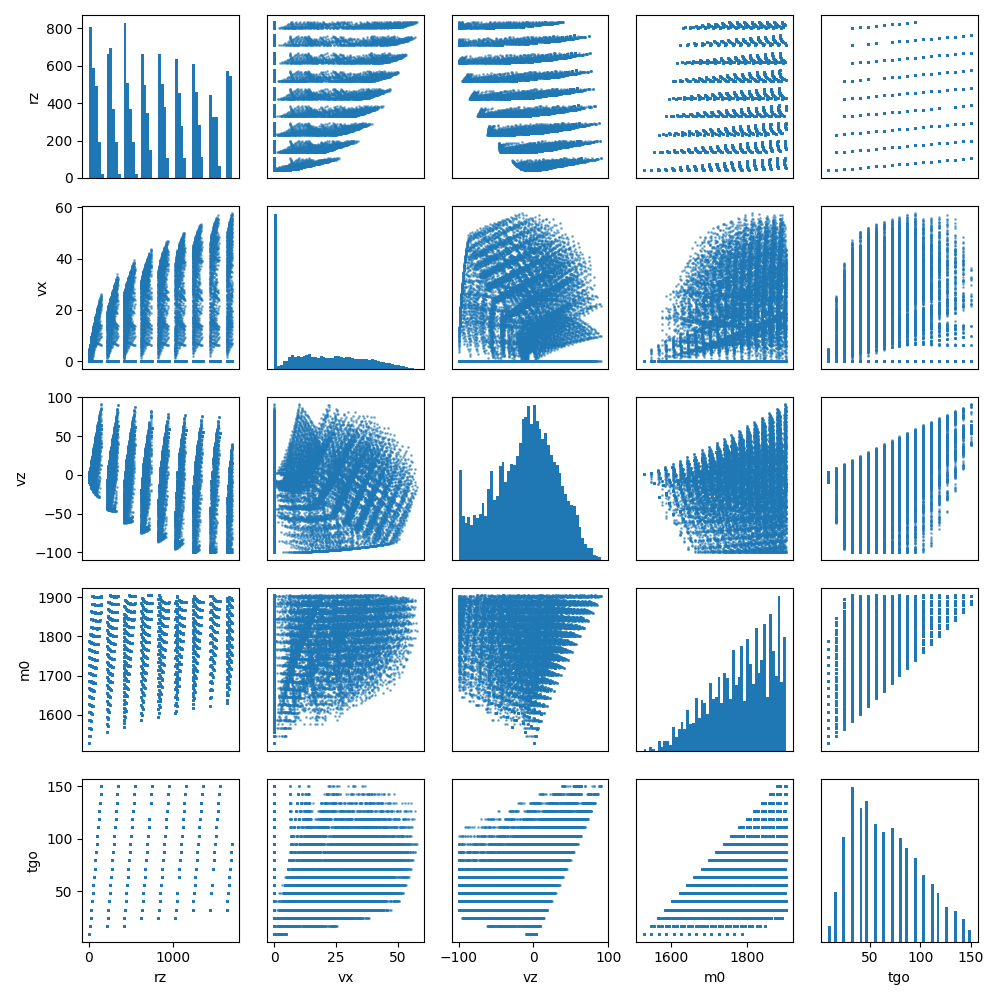

In [3]:
data = np.load("../out/controllable_set/20231113-164418/data.npy")
data = data[(data[:, 3] >= 0)]  # Remove negative vx
data = data[(data[:, 6] <= 1905.0)]  # Remove over-sized initial mass

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
names = ['rx', 'ry', 'rz', 'vx', 'vy', 'vz', 'm0', 'tgo', 'mf']
indices = [2, 3, 5, 6, 7]
for i, y_idx in enumerate(indices):
    for j, x_idx in enumerate(indices):
        if j==i: 
            axs[i, j].hist(data[:, x_idx], bins=50)
        else:
            axs[i, j].scatter(data[:, x_idx], data[:, y_idx], s=1, alpha=0.5)
        if i == 4:
            axs[i, j].set_xlabel(names[x_idx])
        else:
            # remove x tick labels
            axs[i, j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if j == 0:
            axs[i, j].set_ylabel(names[y_idx])
        else:
            # remove y tick labels
            axs[i, j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

plt.tight_layout()
plt.show()

### Convex hull analysis

In [4]:
data_5d = data[:, indices]
data_bounds = (np.min(data_5d, axis=0), np.max(data_5d, axis=0))
data_normalized = (data_5d - data_bounds[0]) / (data_bounds[1] - data_bounds[0])

hull_5d = ConvexHull(data_normalized, qhull_options='Q12')

In [5]:
import numba
from numba.typed import List

@numba.njit
def inside_hull(point, simplex_eqs):
    """Check if a point is inside a convex hull defined by a set of linear equations.
    
    Args:
        point (np.ndarray): Point to check. (n_dim,)
        simplex_eqs (list): List of linear equations defining the convex hull. (n_points, n_dim).  Ax + b <= 0.
    
    """
    for eq in simplex_eqs:
        if not (np.dot(eq[:-1], point) + eq[-1] <= 0):
            return False
    return True


@numba.njit
def random_sampling_in_hull(simplex_eqs, bounds, n_samples):
    """Sample random points in a convex hull defined by a set of linear equations.
    
    Args:
        simplex_eqs (list): List of linear equations defining the convex hull. (n_points, n_dim).  Ax + b <= 0.
        bounds (tuple): Bounds of the convex hull. (lb, ub)
        n_samples (int): Number of samples to generate.
    
    """
    lb, ub = bounds
    samples = np.empty((n_samples, len(lb)))
    i = 0
    while i < n_samples:
        random_point = lb + (ub - lb) * np.random.random(size=lb.shape)
        if inside_hull(random_point, simplex_eqs):
            samples[i] = random_point
            i += 1
    
    return samples

def random_sampling_in_weighted_hull(simplex_eqs, bounds, weighted_dists, n_samples):
    lb, ub = bounds
    samples = np.empty((n_samples, len(lb)))
    i = 0
    pbar = tqdm(total=n_samples)
    while i < n_samples:
        random_point = np.array([np.random.choice(bin_centers, p=weights/weights.sum()) for bin_centers, weights in weighted_dists])
        if inside_hull(random_point, simplex_eqs):
            samples[i] = random_point
            i += 1
            pbar.update(1)
            print(f"{i}/{n_samples} samples generated", end="\r")
    
    return samples


In [6]:
random_samples = random_sampling_in_hull(np.ascontiguousarray(hull_5d.equations), (np.zeros(5), np.ones(5)), 10000)

# denormalize
random_samples = random_samples * (data_bounds[1] - data_bounds[0]) + data_bounds[0]

C:\Users\ktomita3\AppData\Local\Temp\ipykernel_39884\128400202.py:34: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  if inside_hull(random_point, simplex_eqs):


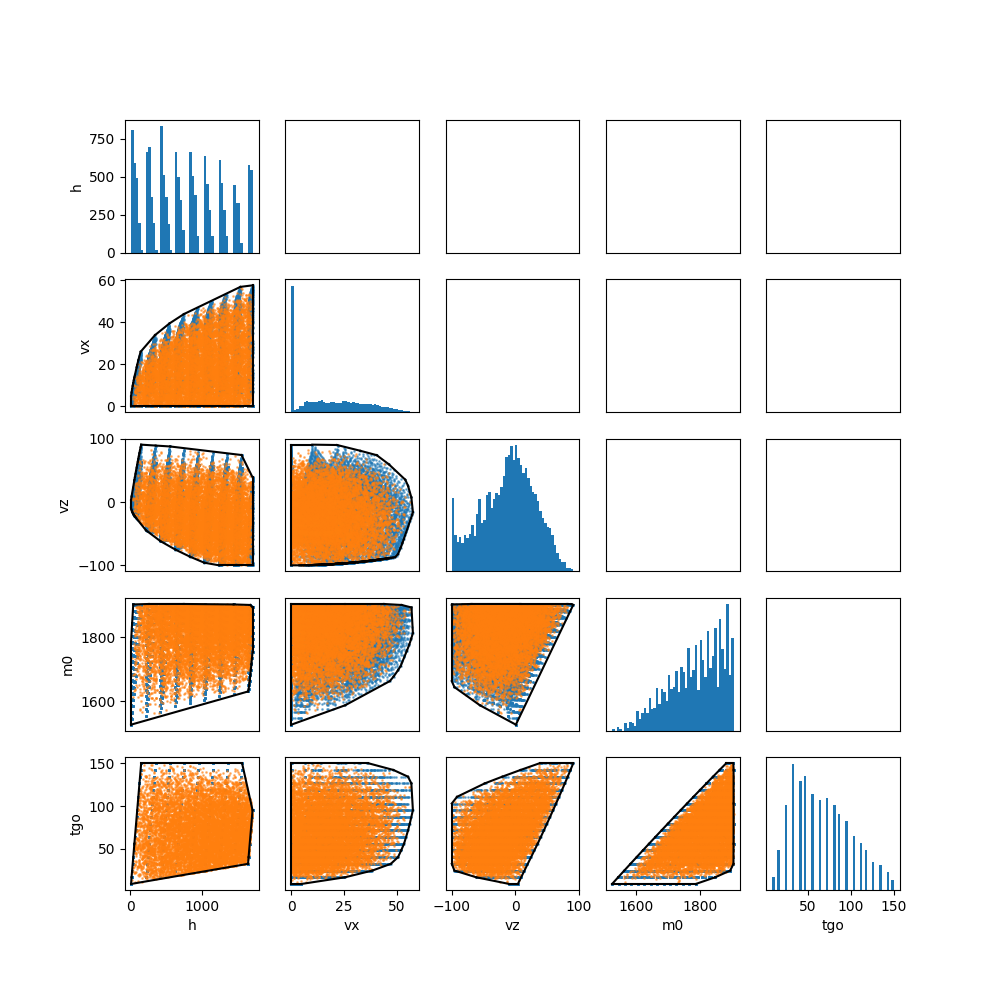

In [7]:
# pair plot of samples and data_5d
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
names = ['h', 'vx', 'vz', 'm0', 'tgo']
for i, y_idx in enumerate(range(5)):
    for j, x_idx in enumerate(range(5)):
        if j==i: 
            axs[i, j].hist(data_5d[:, x_idx], bins=50)
        elif j < i:
            data_ = data_5d[:, [x_idx, y_idx]]
            hull_ = ConvexHull(data_)
            for simplex in hull_.simplices:
                axs[i, j].plot(data_[simplex, 0], data_[simplex, 1], 'k-')
            axs[i, j].scatter(data_5d[:, x_idx], data_5d[:, y_idx], s=1, alpha=0.5)
            axs[i, j].scatter(random_samples[:, x_idx], random_samples[:, y_idx], s=1, alpha=0.5)
        if i == 4:
            axs[i, j].set_xlabel(names[x_idx])
        else:
            # remove x tick labels
            axs[i, j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if j == 0:
            axs[i, j].set_ylabel(names[y_idx])
        else:
            # remove y tick labels
            axs[i, j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

In [8]:
from scipy.optimize import linprog
import time

def structured_sample_points_in_convex_hull(hull, n_per_dim, points, buffer=0.1):
    """
    Samples points within a convex hull.

    Args:
        n_per_dim (int): Number of partitions per dimension.
        points (np.ndarray): Points defining the convex hull. (n_points, n_dim)

    Returns:
        np.ndarray: Sampled points within the convex hull.
    """
    simplex_eqs = hull.equations
    n_dim = points.shape[1]

    # Compute the bounds for each dimension
    def get_bounds(dim, fixed_values):
        bounds = []
        c = np.zeros(n_dim)
        c[dim] = 1  # Objective function to maximize/minimize the current dimension

        A_ub = simplex_eqs[:, :-1]
        b_ub = -simplex_eqs[:, -1]

        # Setting equality constraints for fixed dimensions
        A_eq = np.zeros((len(fixed_values), n_dim))
        b_eq = np.zeros(len(fixed_values))
        for idx, (d, val) in enumerate(fixed_values.items()):
            A_eq[idx, d] = 1
            b_eq[idx] = val

        # Linear programming to find min and max for current dimension
        res_min = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None, None))
        res_max = linprog(-c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None, None))

        if res_min.success and res_max.success:
            return res_min.fun, -res_max.fun
        else:
            return None, None
        
    def add_buffer(bounds, buffer):
        lb, ub = bounds
        scale = (ub - lb) * buffer
        lb += scale/2
        ub -= scale/2
        return lb, ub

    # Sampling points within the convex hull
    samples = []
    start = time.time()
    for dim in range(n_dim):
        if dim == 0:
            min_val, max_val = np.min(points[:, dim]), np.max(points[:, dim])
            min_val, max_val = add_buffer((min_val, max_val), buffer)
            sample_points = np.linspace(min_val, max_val, n_per_dim)
            samples = [[val] for val in sample_points]
        else:
            new_samples = []
            for fixed_values in samples:
                fixed_dict = {i: fixed_values[i] for i in range(len(fixed_values))}
                min_val, max_val = get_bounds(dim, fixed_dict)
                min_val, max_val = add_buffer((min_val, max_val), buffer)
                if min_val is not None and max_val is not None:
                    for point in np.linspace(min_val, max_val, n_per_dim):
                        new_samples.append(fixed_values + [point])

                # len(samples)/n_per_dim ** n_dim is the current progress
                elapsed = time.time() - start
                n_samples = max(len(samples), len(new_samples))
                t_per_sample = elapsed / n_samples
                t_remaining = (n_per_dim ** n_dim - n_samples) * t_per_sample
                t_total = elapsed + t_remaining
                print(f"{n_samples / n_per_dim ** n_dim * 100:.2f}% completed. {t_total/60:.2f}m remaining ({t_total/60:.2f}m)", end="\r")
                 

            samples = new_samples

    return np.array(samples)

In [9]:
structured_samples = structured_sample_points_in_convex_hull(hull_5d, 5, hull_5d.points, buffer=0.1)
print(structured_samples.shape)
# denormalize
structured_samples = structured_samples * (data_bounds[1] - data_bounds[0]) + data_bounds[0]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


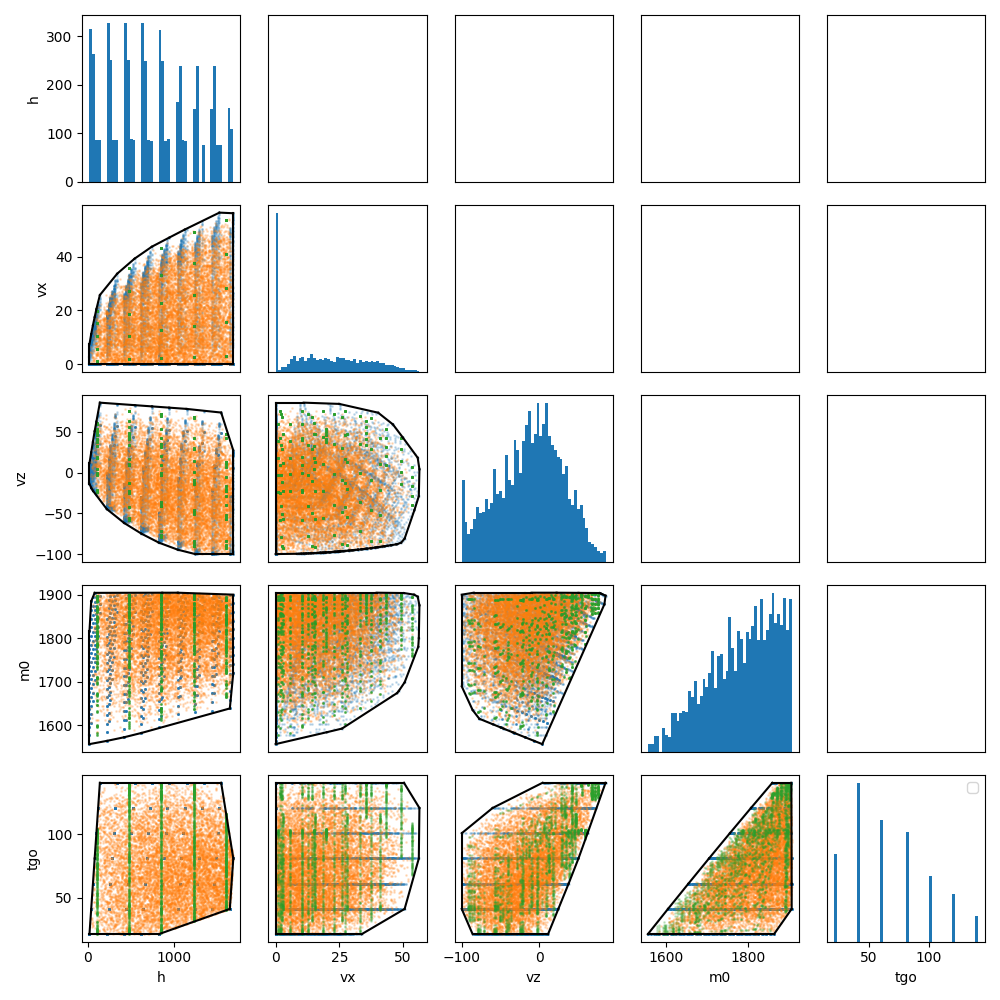

In [43]:
# pair plot of samples and data_5d
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
names = ['h', 'vx', 'vz', 'm0', 'tgo']
for i, y_idx in enumerate(range(5)):
    for j, x_idx in enumerate(range(5)):
        if j==i: 
            axs[i, j].hist(data_5d[:, x_idx], bins=50)
        elif j < i:
            data_ = data_5d[:, [x_idx, y_idx]]
            hull_ = ConvexHull(data_)
            for simplex in hull_.simplices:
                axs[i, j].plot(data_[simplex, 0], data_[simplex, 1], 'k-')
            axs[i, j].scatter(data_5d[:, x_idx], data_5d[:, y_idx], s=1, alpha=0.2)
            axs[i, j].scatter(random_samples[:, x_idx], random_samples[:, y_idx], s=1, alpha=0.2, label='random')
            axs[i, j].scatter(structured_samples[:, x_idx], structured_samples[:, y_idx], s=1, alpha=0.2, label='structured')
        if i == 4:
            axs[i, j].set_xlabel(names[x_idx])
        else:
            # remove x tick labels
            axs[i, j].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        if j == 0:
            axs[i, j].set_ylabel(names[y_idx])
        else:
            # remove y tick labels
            axs[i, j].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

plt.legend()
plt.tight_layout()
plt.show()

In [88]:
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import linprog

def sample_points_in_convex_hull(hull, n_per_dim, points):
    """
    Samples points within a convex hull.

    Args:
        n_per_dim (int): Number of partitions per dimension.
        points (np.ndarray): Points defining the convex hull. (n_points, n_dim)

    Returns:
        np.ndarray: Sampled points within the convex hull.
    """
    simplex_eqs = hull.equations
    n_dim = points.shape[1]

    # Compute the bounds for each dimension
    def get_bounds(dim, fixed_values):
        bounds = []
        c = np.zeros(n_dim)
        c[dim] = 1  # Objective function to maximize/minimize the current dimension

        A_ub = simplex_eqs[:, :-1]
        b_ub = -simplex_eqs[:, -1]

        # Setting equality constraints for fixed dimensions
        A_eq = np.zeros((len(fixed_values), n_dim))
        b_eq = np.zeros(len(fixed_values))
        for idx, (d, val) in enumerate(fixed_values.items()):
            A_eq[idx, d] = 1
            b_eq[idx] = val

        # Linear programming to find min and max for current dimension
        res_min = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None, None), method='highs')
        res_max = linprog(-c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(None, None), method='highs')

        if res_min.success and res_max.success:
            return res_min.fun, -res_max.fun
        else:
            raise ValueError("Linear programming failed to find bounds.")

    # Sampling points within the convex hull
    samples = []
    for dim in range(n_dim):
        if dim == 0:
            min_val, max_val = np.min(points[:, dim]), np.max(points[:, dim])
            sample_points = np.linspace(min_val, max_val, n_per_dim)
            samples = [[val] for val in sample_points]
        else:
            new_samples = []
            for fixed_values in samples:
                fixed_dict = {i: fixed_values[i] for i in range(len(fixed_values))}
                min_val, max_val = get_bounds(dim, fixed_dict)
                for point in np.linspace(min_val, max_val, n_per_dim):
                    new_samples.append(fixed_values + [point])
            samples = new_samples

    return np.array(samples)

# Example usage:
# points = np.array(...)  # Define your convex hull points here
# n_per_dim = ...        # Define the number of partitions per dimension
# sampled_points = sample_points_in_convex_hull(n_per_dim, points)


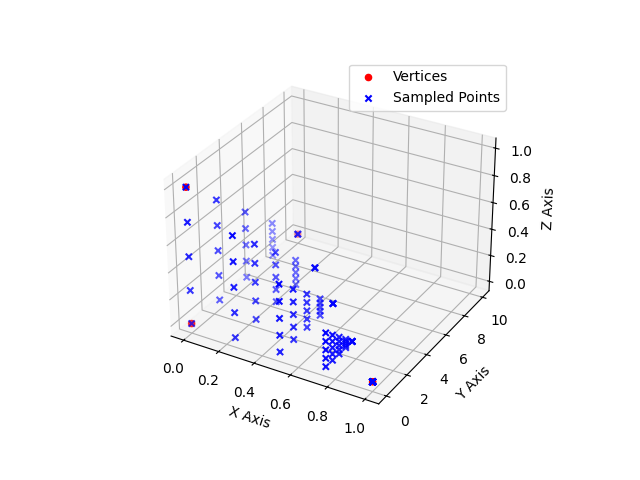

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convex hull vertices
vertices = np.array([[0, 0, 0], [0, 10, 0], [1, 0, 0], [0, 0, 1]])
hull = ConvexHull(vertices)

# Number of partitions per dimension
n_per_dim = 5

# Generate sample points
sampled_points = sample_points_in_convex_hull(hull, n_per_dim, vertices)

# Now we'll create a 3D plot to visualize these points and the convex hull
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices of the convex hull
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='r', marker='o', label='Vertices')

# Plot the sampled points
ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='b', marker='x', label='Sampled Points')

# Setting labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

plt.show()


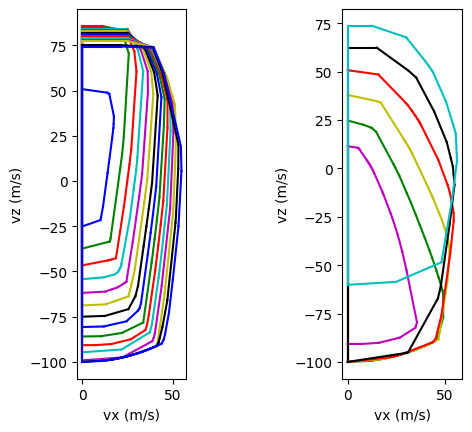

In [6]:
fig, axs = plt.subplots(1, 2)

x_idx = 3  # vx
y_idx = 5  # vz
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# group by algitude
group_idx = 2
group_ranges = np.arange(0, np.max(data[:, group_idx]), 100)

for i in range(len(group_ranges)-1):
        group = data[(data[:, group_idx] >= group_ranges[i]) & (data[:, group_idx] < group_ranges[i+1])]
        #axs[0].scatter(group[:, x_idx], group[:, y_idx], s=1, alpha=0.5, color=colors[i % len(colors)])
        # Calculate convex hull for each group
        if len(group) >= 3:  # ConvexHull requires at least 3 points in 2D
            hull = ConvexHull(group[:, [x_idx, y_idx]])
            for s in hull.simplices:
                axs[0].plot(group[s, x_idx], group[s, y_idx], color=colors[i % len(colors)])

# group by time to go
group_idx = 7
group_ranges = np.arange(0, np.max(data[:, group_idx]), 5)

for i in range(len(group_ranges)-1):
        group = data[(data[:, group_idx] >= group_ranges[i]) & (data[:, group_idx] < group_ranges[i+1])]
        # Calculate convex hull for each group
        if len(group) >= 3:  # ConvexHull requires at least 3 points in 2D
            hull = ConvexHull(group[:, [x_idx, y_idx]])
            for s in hull.simplices:
                axs[1].plot(group[s, x_idx], group[s, y_idx], color=colors[i % len(colors)])

for ax in axs:
    ax.set_xlabel('vx (m/s)')
    ax.set_ylabel('vz (m/s)')
    # aspect ratio
    ax.set_aspect('equal', 'box')
plt.show()


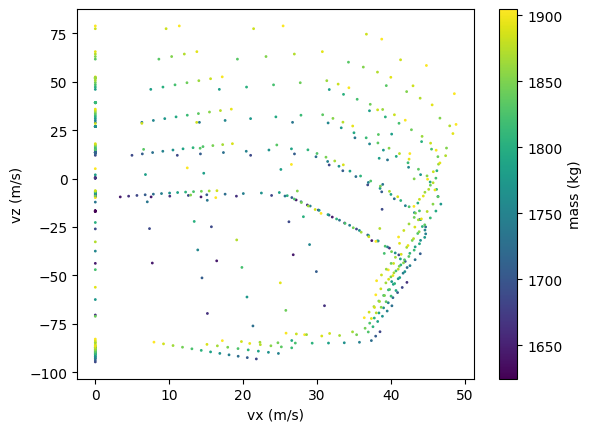

In [7]:
# group by altitude
groupby_idx = 2
group_ranges = np.arange(0, np.max(data[:, groupby_idx]), 100)
group_idx = 10
group = data[(data[:, groupby_idx] >= group_ranges[group_idx]) & (data[:, groupby_idx] < group_ranges[group_idx+1])]

fig, ax = plt.subplots()
scatter = ax.scatter(group[:, 3], group[:, 5], s=1, c=group[:, 6])
ax.set_xlabel('vx (m/s)')
ax.set_ylabel('vz (m/s)')

cb = fig.colorbar(scatter)
cb.set_label('mass (kg)')

plt.show()

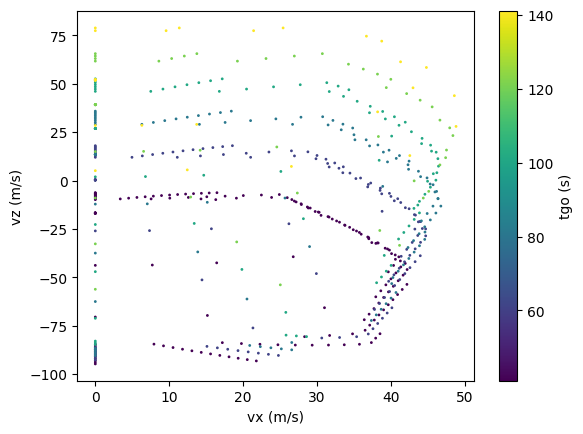

In [8]:
# group by altitude
groupby_idx = 2
group_ranges = np.arange(0, np.max(data[:, groupby_idx]), 100)
group_idx = 10
group = data[(data[:, groupby_idx] >= group_ranges[group_idx]) & (data[:, groupby_idx] < group_ranges[group_idx+1])]

fig, ax = plt.subplots()
scatter = ax.scatter(group[:, 3], group[:, 5], s=1, c=group[:, 7])
ax.set_xlabel('vx (m/s)')
ax.set_ylabel('vz (m/s)')

cb = fig.colorbar(scatter)
cb.set_label('tgo (s)')

plt.show()

In [9]:
data.shape

(10459, 9)

In [11]:
m0_ranges = np.arange(np.min(data[:, 6]), np.max(data[:, 6]), 100)
alt_ranges = np.arange(np.min(data[:, 2]), np.max(data[:, 2]), 200)
tgo_ranges = np.arange(np.min(data[:, 7]), np.max(data[:, 7]), 20)

n_m0 = len(m0_ranges) - 1
n_alt = len(alt_ranges) - 1
n_tgo = len(tgo_ranges) - 1
print(n_m0, n_alt, n_tgo)

3 7 5


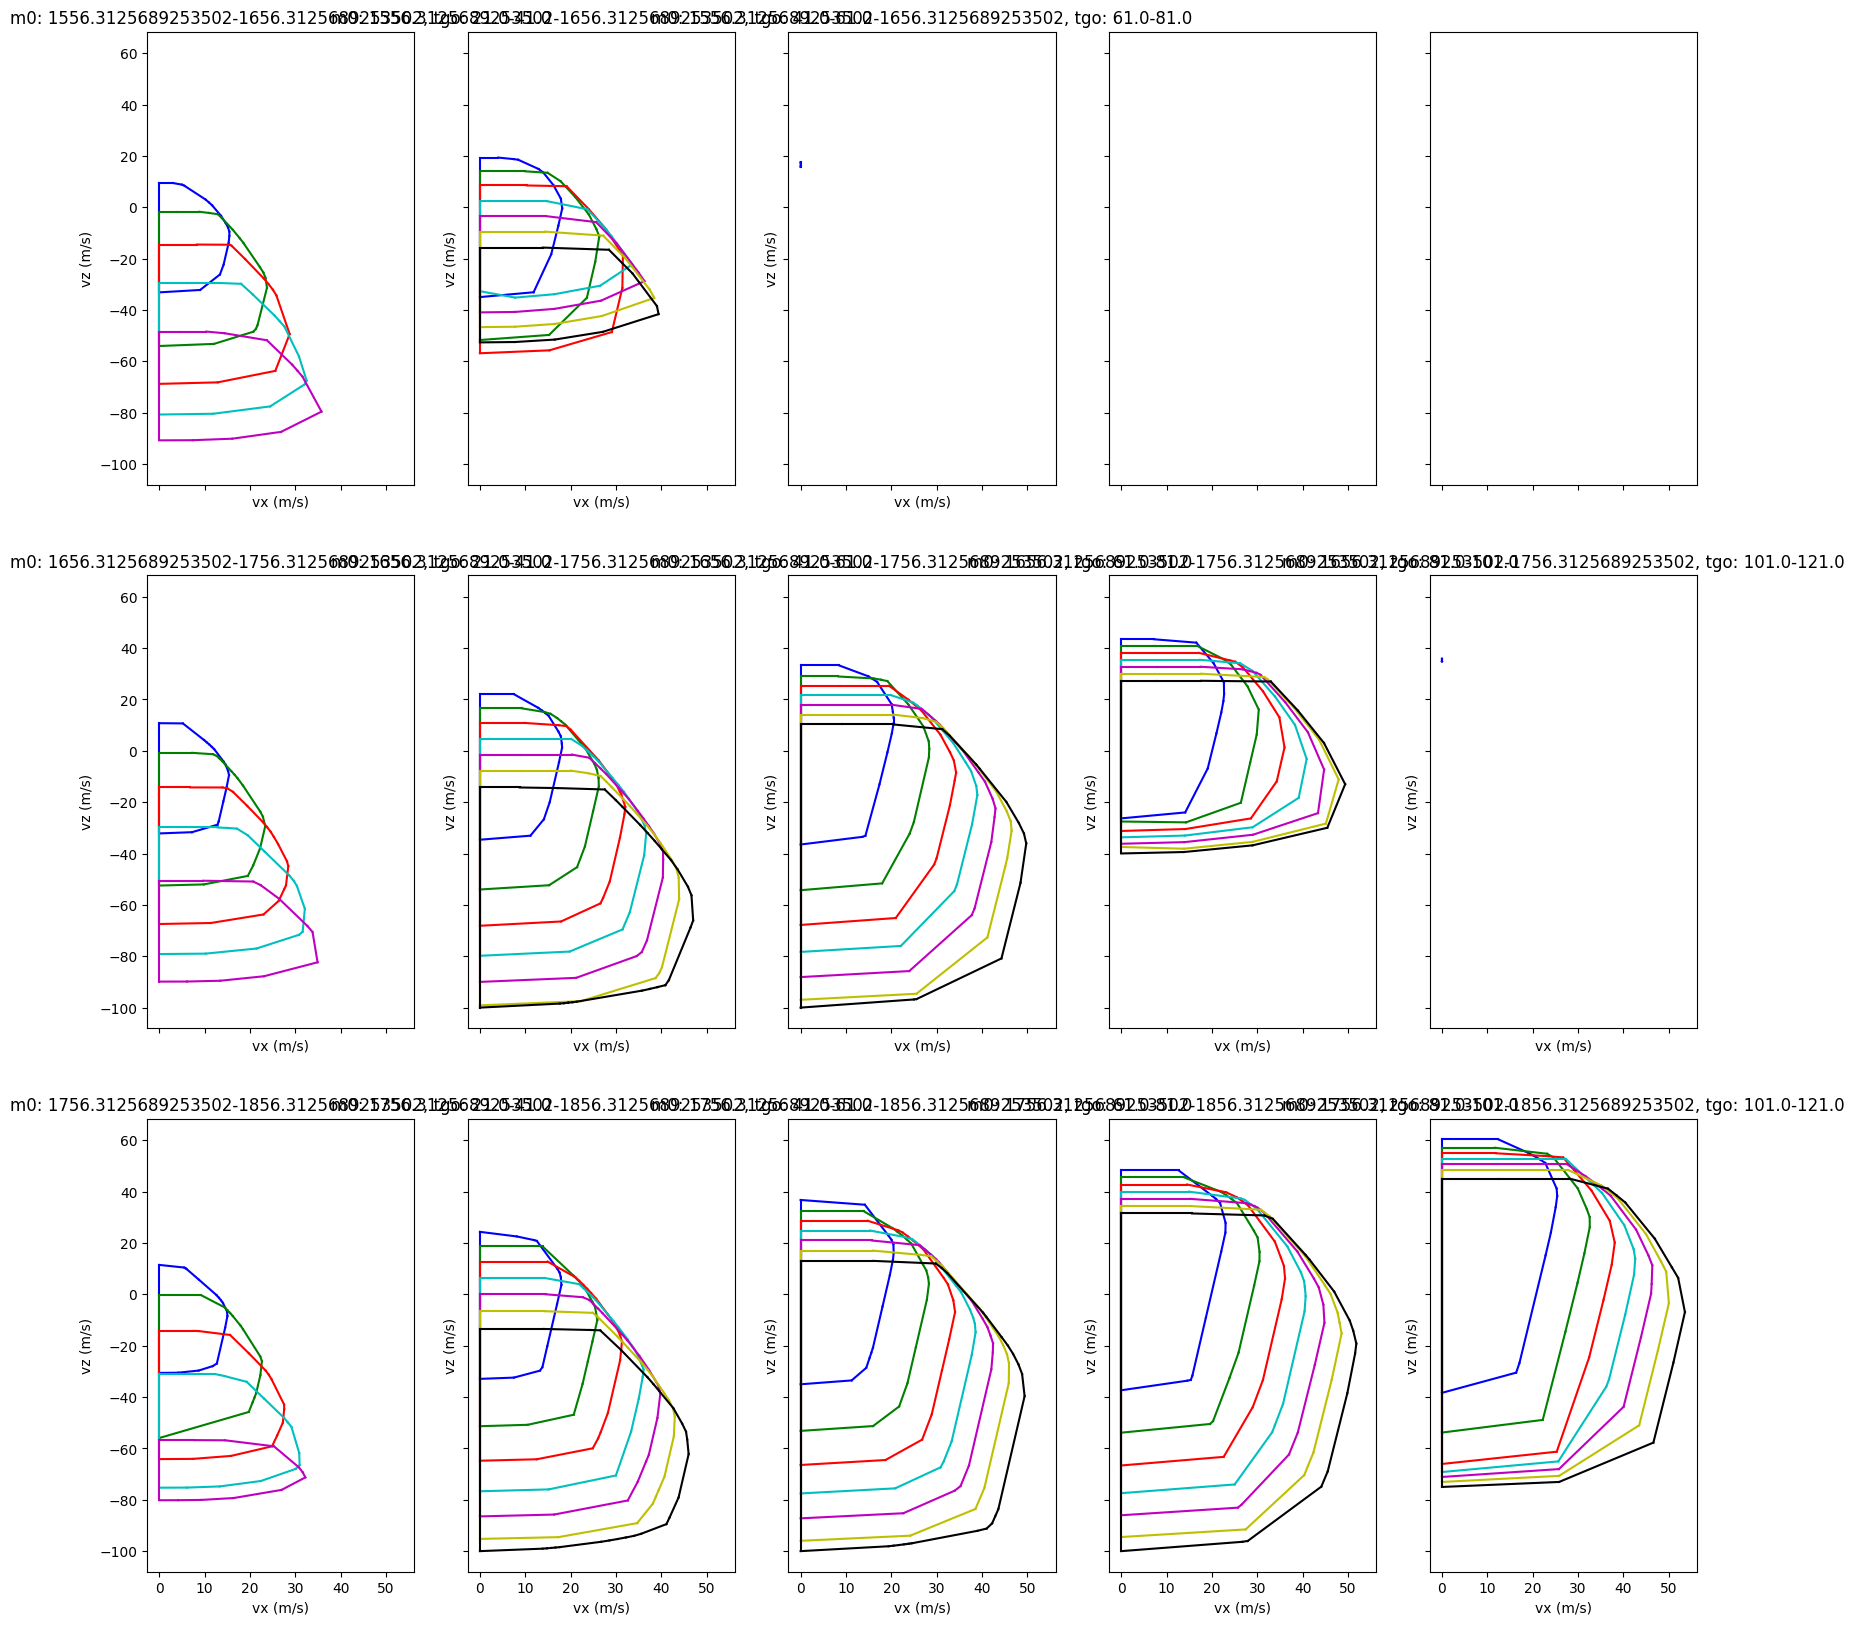

In [12]:
fig, axs = plt.subplots(n_m0, n_tgo, figsize=(20, 20), sharex=True, sharey=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i in range(n_m0):
    for j in range(n_tgo):
        group = data[(data[:, 6] >= m0_ranges[i]) & (data[:, 6] < m0_ranges[i+1]) & (data[:, 7] >= tgo_ranges[j]) & (data[:, 7] < tgo_ranges[j+1])]
        
        for k in range(n_alt):
            subgroup = group[(group[:, 2] >= alt_ranges[k]) & (group[:, 2] < alt_ranges[k+1])]
            if len(subgroup) >= 3:
                hull = ConvexHull(subgroup[:, [3, 5]])
                for s in hull.simplices:
                    axs[i, j].plot(subgroup[s, 3], subgroup[s, 5], color=colors[k % len(colors)])
                    axs[i, j].set_xlabel('vx (m/s)')
                    axs[i, j].set_ylabel('vz (m/s)')
                    axs[i, j].set_title(f'm0: {m0_ranges[i]}-{m0_ranges[i+1]}, tgo: {tgo_ranges[j]}-{tgo_ranges[j+1]}')
plt.show()

### Convex Reachable Set
Given the initial altitude, mass, and time-to-go, we numerically examine if the function mapping the initial velocity to the reachable surface is convex or not. 

Number of points: 33


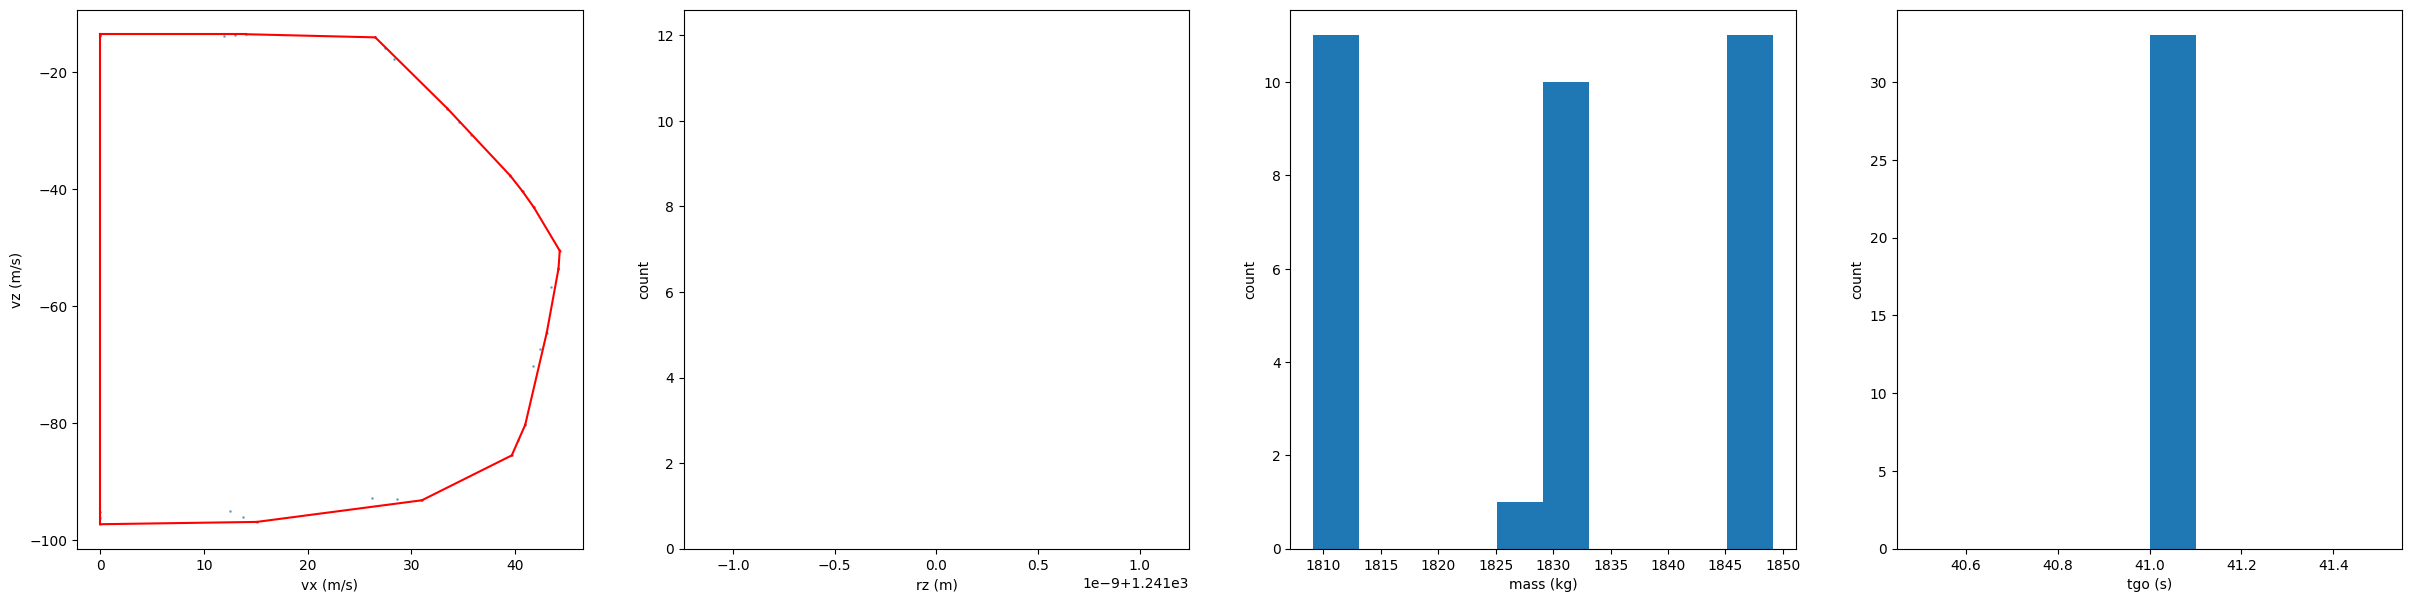

Average rz: 1241.0
Average mass: 1829.1167735111487
Average tgo: 41.0


In [13]:
# Extract data for the given altitude, mass, and time-to-go
alt_range = [1200.0, 1250.0]
m_range = [1800.0, 1850.0]
tgo_range = [40.0, 50.0]

group = data[(data[:, 2] >= alt_range[0]) & (data[:, 2] < alt_range[1]) & (data[:, 6] >= m_range[0]) & (data[:, 6] < m_range[1]) & (data[:, 7] >= tgo_range[0]) & (data[:, 7] < tgo_range[1])]
print(f'Number of points: {len(group)}')
fig, axs = plt.subplots(1, 4, figsize=(30, 7))
axs[0].scatter(group[:, 3], group[:, 5], s=1, alpha=0.5)
if len(group) >= 3:
    hull = ConvexHull(group[:, [3, 5]])
    for s in hull.simplices:
        axs[0].plot(group[s, 3], group[s, 5], color='r')
axs[0].set_xlabel('vx (m/s)')
axs[0].set_ylabel('vz (m/s)')

# histgrams
axs[1].hist(group[:, 2])
axs[1].set_xlabel('rz (m)')
axs[1].set_ylabel('count')
axs[2].hist(group[:, 6])   
axs[2].set_xlabel('mass (kg)')
axs[2].set_ylabel('count')
axs[3].hist(group[:, 7])
axs[3].set_xlabel('tgo (s)')
axs[3].set_ylabel('count')
plt.show()

print(f'Average rz: {np.mean(group[:, 2])}')
print(f'Average mass: {np.mean(group[:, 6])}')
print(f'Average tgo: {np.mean(group[:, 7])}')

In [14]:
import cvxpy as cp
import sys
sys.path.append('..')
import src.lcvx as lc
from config.landers import get_lander

In [15]:
lander = get_lander(planet='mars')
lander.gsa = (np.pi - lander.fov) / 2  # set glide-slope angle to be FOV/2
N = 100
lcvx = lc.LCvxReachabilityRxy(rocket=lander, N=N)
prob = lcvx.problem(tf = np.mean(group[:, 7]))

In [16]:
def _solve(lcvx, prob):
    try:
        prob.solve(solver=cp.ECOS, verbose=False)
    except cp.SolverError:
        return None
    if prob.status != 'optimal':
        return None

    # Get solution
    sol = lc.get_vars(prob, ['X', 'U'])
    X_sol = sol['X']
    U_sol = sol['U']
    r, v, z, u, sigma = lcvx.recover_variables(X_sol, U_sol)
    valid, _ = lc.isolated_active_set_gs(r, lander.gsa)
    
    if not valid:
        return None
    return r, v, z, u, sigma

In [17]:
n = 30
n_theta = 10
theta_list = np.linspace(0, 180, 11) * np.pi / 180
alt_range = [800.0, 850.0]
m_range = [1800.0, 1850.0]
tgo_range = [40.0, 50.0]

from src.visualization import *

for theta in theta_list:
    v_xz = np.zeros((n, n, 2))
    max_range_data = np.zeros((n, n))
    pbar = tqdm(total=n*n)
    for i, vx in enumerate(np.linspace(np.min(group[:, 3]), np.max(group[:, 3]), n)):
        for j, vz in enumerate(np.linspace(np.min(group[:, 5]), np.max(group[:, 5]), n)):
            v_xz[i, j] = np.array([vx, vz])
            
            # solve for center point
            lc.set_params(prob, {'alt': np.mean(group[:, 2]), 
                                'z_mass': np.mean(np.log(group[:, 6])),
                                'vx': vx,
                                'vz': vz,
                                'c': np.array([1.0, 0.0]),
                                'c_xc_arr': np.zeros((2,2))})
            sol_xmax = _solve(lcvx, prob)
            

            lc.set_params(prob, {'alt': np.mean(group[:, 2]), 
                                'z_mass': np.mean(np.log(group[:, 6])),
                                'vx': vx,
                                'vz': vz,
                                'c': np.array([-1.0, 0.0]),
                                'c_xc_arr': np.zeros((2,2))})
            sol_xmin = _solve(lcvx, prob)

            if sol_xmax is None or sol_xmin is None:
                max_range_data[i, j] = np.nan
                pbar.update(1)
                continue

            else:
                r_max, _, _, _, _ = sol_xmax
                r_min, _, _, _, _ = sol_xmin
                rc = (r_max[:2, -1] + r_min[:2, -1]) / 2

                c = np.array([np.cos(theta), np.sin(theta)])

                lc.set_params(prob, {'alt': np.mean(group[:, 2]), 
                                    'z_mass': np.mean(np.log(group[:, 6])),
                                    'vx': vx,
                                    'vz': vz,
                                    'c': c,
                                    'c_xc_arr': np.array([
                                        [c[0] * rc[0], c[0] * rc[1]],
                                        [c[1] * rc[0], c[1] * rc[1]]
                                    ])})
                
                sol = _solve(lcvx, prob)
                if sol is None:
                    max_range_data[i, j] = np.nan
                else:
                    r, v, z, u, sigma = sol
                    max_range_data[i, j] = c[0] * (r[0, -1] - rc[0]) + c[1] * (r[1, -1] - rc[1])

                pbar.update(1)
    
   

    group = data[(data[:, 2] >= alt_range[0]) & (data[:, 2] < alt_range[1]) & (data[:, 6] >= m_range[0]) & (data[:, 6] < m_range[1]) & (data[:, 7] >= tgo_range[0]) & (data[:, 7] < tgo_range[1])]
    print(f'Number of points: {len(group)}')
    fig, ax = plt.subplots()
    ax.scatter(group[:, 3], group[:, 5], s=1, alpha=0.5)
    cs = ax.contourf(v_xz[:, :, 0], v_xz[:, :, 1], max_range_data, levels=10)
    #cs = ax.scatter(v_xz[:, :, 0], v_xz[:, :, 1], c=max_range_data, s=50, alpha=0.5)
    cbar = fig.colorbar(cs)
    cbar.set_label('max range (m)')
    if len(group) >= 3:
        hull = ConvexHull(group[:, [3, 5]])
        for s in hull.simplices:
            ax.plot(group[s, 3], group[s, 5], color='r')
    ax.set_xlabel('vx (m/s)')
    ax.set_ylabel('vz (m/s)')
    plt.title(f'theta: {theta * 180 / np.pi} deg')
    plt.show()


  0%|          | 0/900 [00:00<?, ?it/s]

  6%|▌         | 56/900 [00:04<00:54, 15.52it/s]c:\Users\ktomita3\.conda\envs\learn-reach\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 31%|███       | 280/900 [00:19<00:38, 16.18it/s]

KeyboardInterrupt: 

In [ ]:
alt_range = [800.0, 850.0]
m_range = [1800.0, 1850.0]
tgo_range = [40.0, 50.0]

group = data[(data[:, 2] >= alt_range[0]) & (data[:, 2] < alt_range[1]) & (data[:, 6] >= m_range[0]) & (data[:, 6] < m_range[1]) & (data[:, 7] >= tgo_range[0]) & (data[:, 7] < tgo_range[1])]
print(f'Number of points: {len(group)}')
fig, ax = plt.subplots()
ax.scatter(group[:, 3], group[:, 5], s=1, alpha=0.5)
cs = ax.contourf(v_xz[:, :, 0], v_xz[:, :, 1], max_range_data, levels=10)
#cs = ax.scatter(v_xz[:, :, 0], v_xz[:, :, 1], c=max_range_data, s=50, alpha=0.5)
cbar = fig.colorbar(cs)
cbar.set_label('max range (m)')
if len(group) >= 3:
    hull = ConvexHull(group[:, [3, 5]])
    for s in hull.simplices:
        ax.plot(group[s, 3], group[s, 5], color='r')
ax.set_xlabel('vx (m/s)')
ax.set_ylabel('vz (m/s)')
plt.show()

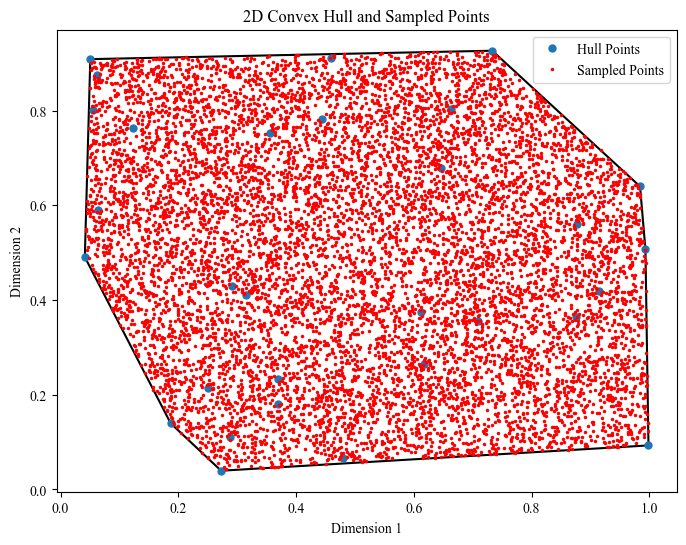

In [18]:
import numpy as np
from scipy.spatial import ConvexHull

def sample_points_in_hull(points, n_samples):
    hull = ConvexHull(points)
    min_bounding = np.min(points, axis=0)
    max_bounding = np.max(points, axis=0)

    def is_inside_hull(point, hull):
        return all(
            np.dot(eq[:-1], point) + eq[-1] <= 0
            for eq in hull.equations
        )

    samples = []
    while len(samples) < n_samples:
        random_point = np.random.uniform(min_bounding, max_bounding)
        if is_inside_hull(random_point, hull):
            samples.append(random_point)

    return np.array(samples)

# Generate some random points in 2D space to create the hull
num_points = 30
dimension = 2
n_samples = 10000
initial_points = np.random.rand(num_points, dimension)

# Create the convex hull
hull = ConvexHull(initial_points)

# Sample points inside the convex hull
sampled_points = sample_points_in_hull(initial_points, n_samples)

# Plotting
plt.figure(figsize=(8, 6))

# Plot the convex hull
for simplex in hull.simplices:
    plt.plot(initial_points[simplex, 0], initial_points[simplex, 1], 'k-')

# Plot the points
plt.plot(initial_points[:, 0], initial_points[:, 1], 'o', markersize=5, label='Hull Points')
plt.plot(sampled_points[:, 0], sampled_points[:, 1], 'r.', markersize=3, label='Sampled Points')

plt.title('2D Convex Hull and Sampled Points')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [32]:
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_convex_hull(points, sampled_points):
    hull = ConvexHull(points)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the vertices of the convex hull
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', s=20)

    # Plot the sampled points
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], color='red', s=10)

    # Plot the sides of the convex hull
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'k-')

    ax.set_title('3D Convex Hull with Sampled Points')
    plt.show()




In [29]:
# Generate some random points in 2D space to create the hull
num_points = 30
dimension = 3
n_samples = 10000
initial_points = np.random.rand(num_points, dimension)

# Create the convex hull
hull = ConvexHull(initial_points)

# Sample points inside the convex hull
sampled_points = sample_points_in_hull(initial_points, n_samples)

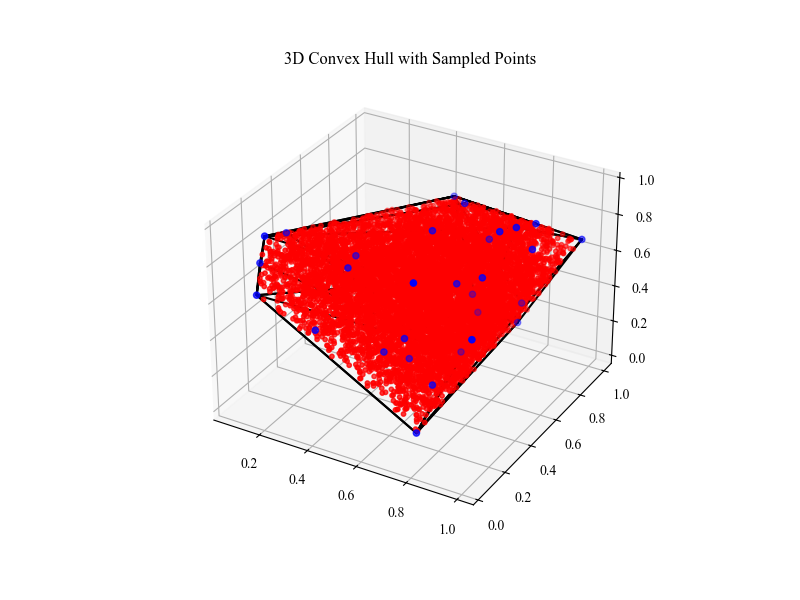

In [30]:
visualize_3d_convex_hull(initial_points, sampled_points)
%matplotlib widget

In [44]:
from scipy.optimize import linprog

def intersect_hull_with_subspace(hull, k_dimension, scalar):
    """
    Computes the exact intersection of an n-dimensional convex hull
    with a subspace specified by a scalar in the k-th dimension.

    :param hull: An n-dimensional scipy.spatial.ConvexHull object.
    :param k_dimension: The index of the dimension (0-indexed) to intersect.
    :param scalar: The scalar value in the k-th dimension defining the subspace.
    :return: Points of intersection forming the (n-1)-dimensional subspace.
    """
    points = hull.points
    intersected_points = []

    for simplex in hull.simplices:
        # Form the system of linear equations
        n_dim = points.shape[1]
        A = points[simplex]
        b = np.zeros(len(simplex))
        b = np.insert(b, k_dimension, -scalar)     # Inserting scalar in kth dimension
        print(f"A shape: {A.shape}, simplex: {simplex.shape}, b shape: {b.shape}")

        # Solve the linear system
        try:
            solution = np.linalg.solve(A, b)
            if np.all(solution >= 0) and np.all(solution <= 1):
                # Compute the intersection point
                intersect_point = np.dot(solution, points[simplex])
                intersected_points.append(intersect_point)
        except np.linalg.LinAlgError:
            pass  # Skip if the system is singular

    # Remove the k-th dimension and compute the (n-1)-dimensional convex hull
    intersected_points = np.array(intersected_points)
    if intersected_points.size > 0:
        intersected_points = np.delete(intersected_points, k_dimension, axis=1)
        return ConvexHull(intersected_points)
    else:
        raise ValueError("No intersection found or not enough points for a hull.")

n_dim: 3
A shape: (3, 3), simplex: (3,), b shape: (4,)
n_dim: 3
A shape: (3, 3), simplex: (3,), b shape: (4,)


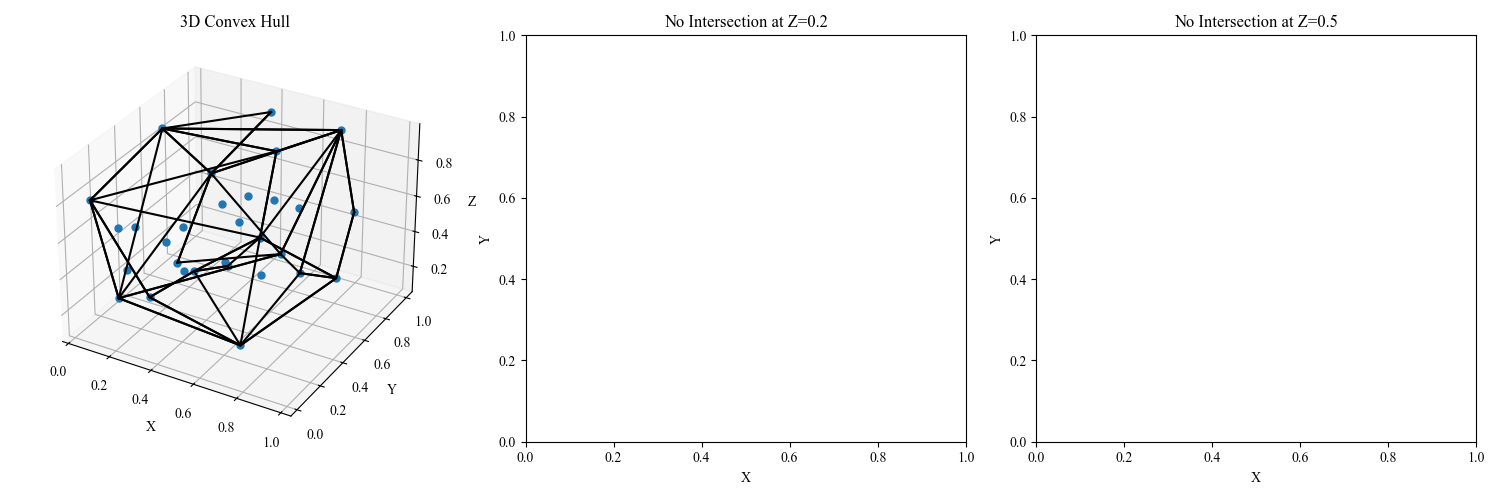

In [45]:
# Function for intersecting hull with subspace (as defined previously)

# Generate a 3D convex hull
np.random.seed(0)  # For reproducible results
points_3d = np.random.rand(30, 3)  # 30 random points in 3D
hull_3d = ConvexHull(points_3d)

# Scalars for slicing in the 3rd dimension
scalars = [0.2, 0.5]

# Plotting
fig = plt.figure(figsize=(15, 5))

# Plotting 3D convex hull
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], 'o', markersize=5)
for simplex in hull_3d.simplices:
    ax1.plot(points_3d[simplex, 0], points_3d[simplex, 1], points_3d[simplex, 2], 'k-')
ax1.set_title('3D Convex Hull')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Plotting sliced 2D convex hulls
for i, scalar in enumerate(scalars, start=1):
    ax = fig.add_subplot(1, 3, i + 1)
    try:
        sliced_hull = intersect_hull_with_subspace(hull_3d, 2, scalar)
        ax.scatter(sliced_hull.points[:, 0], sliced_hull.points[:, 1], color='red', s=10)
        for simplex in sliced_hull.simplices:
            ax.plot(sliced_hull.points[simplex, 0], sliced_hull.points[simplex, 1], 'k-')
        ax.set_title(f'2D Slice at Z={scalar}')
    except ValueError:
        ax.set_title(f'No Intersection at Z={scalar}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

plt.tight_layout()
plt.show()

In [46]:
hull_3d

In [47]:
hull_3d.equations

array([[-9.97730571e-01,  5.15455686e-04,  6.73308431e-02,
         3.08601481e-02],
       [-3.33658012e-01, -8.91588641e-01, -3.06173196e-01,
         3.02023762e-01],
       [-8.60748821e-02, -8.18868178e-01, -5.67490988e-01,
         3.03165172e-01],
       [-1.77786683e-02, -1.25015922e-01,  9.91995433e-01,
        -8.48184964e-01],
       [-1.39335311e-02, -1.71206936e-01,  9.85136560e-01,
        -8.15568702e-01],
       [ 1.32400537e-02, -1.94314838e-01,  9.80849858e-01,
        -8.13899920e-01],
       [ 6.10612362e-02, -1.75452329e-01,  9.82592492e-01,
        -8.56452592e-01],
       [ 9.54839539e-01, -2.96540499e-01, -1.85792141e-02,
        -7.39553978e-01],
       [ 8.29941814e-01, -4.96028303e-01, -2.55249893e-01,
        -4.19326282e-01],
       [ 7.17855954e-01, -8.59554923e-02,  6.90865025e-01,
        -1.15991532e+00],
       [-9.97210468e-01,  5.85776227e-02,  4.62595278e-02,
         1.69520810e-02],
       [ 7.69254213e-02,  9.91588130e-01,  1.04093512e-01,
      